In [1]:
!pip install --quiet bambi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 3.4 MB/s eta 0:00:00


In [2]:
import numpy as np 
import pandas as pd 
import bambi as bmb
import arviz as az

import umap


import matplotlib.pyplot as plt
import seaborn as sns

from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE, mutual_info_classif

from sklearn.impute import SimpleImputer

from statsmodels.miscmodels.ordinal_model import OrderedModel
from statsmodels.discrete.discrete_model import MNLogit
import statsmodels.api as sm

from itertools import combinations
from collections import defaultdict

from sklearn.preprocessing import StandardScaler



import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")
warnings.filterwarnings("ignore",category =RuntimeWarning)

2025-07-24 05:01:03.791966: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753333263.993317      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753333264.052953      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df = pd.read_csv('/kaggle/input/df-als/DF_SLA_ST.csv')

## EDA

In [4]:
df.head()

,Patient_ID,Visit_ID,Date_of_birth,Symptom_onset_date,Diagnosis_date,Sex,Age_at_onset,Clinical_onset_type,Spirometry,FVC,...,MRC_Bulbar,PUMNS_Upper_Limb,PUMNS_Lower_Limb,PUMNS_Bulbar,CNS_Linear_Score,KINGS_Total,Disease_duration,Progression_rate,ALSFRS_R,ALSAQ_5
0,1,1,22-06-1941,01-10-2018,12-12-2019,0,77,spinale,1.0,>80,...,11,4,4,0,7,3,14,0.785714,37,35
1,1,2,22-06-1941,01-10-2018,12-12-2019,0,77,spinale,1.0,60-80,...,13,0,6,0,7,4B,19,0.684211,35,30
2,1,3,22-06-1941,01-10-2018,12-12-2019,0,77,spinale,NaN,ND,...,12,1,3,2,7,4B,23,0.565217,35,25
3,1,4,22-06-1941,01-10-2018,12-12-2019,0,77,spinale,1.0,40-60,...,12,4,5,0,7,4B,26,0.538462,34,45
4,1,5,22-06-1941,01-10-2018,12-12-2019,0,77,spinale,NaN,ND,...,11,1,4,0,7,4B,29,0.689655,28,50


In [5]:
# Basic info
print(df.shape)
print(df.columns)
print(df.dtypes)

(1412, 28)
Index(['Patient_ID', 'Visit_ID', 'Date_of_birth', 'Symptom_onset_date',
       'Diagnosis_date', 'Sex', 'Age_at_onset', 'Clinical_onset_type',
       'Spirometry', 'FVC', 'Ventilation', 'Tracheostomy', 'PEG',
       'Family_history', 'Therapy', 'Diagnostic_delay', 'MRC_Upper_Limb',
       'MRC_Lower_Limb', 'MRC_Bulbar', 'PUMNS_Upper_Limb', 'PUMNS_Lower_Limb',
       'PUMNS_Bulbar', 'CNS_Linear_Score', 'KINGS_Total', 'Disease_duration',
       'Progression_rate', 'ALSFRS_R', 'ALSAQ_5'],
      dtype='object')
Patient_ID               int64
Visit_ID                 int64
Date_of_birth           object
Symptom_onset_date      object
Diagnosis_date          object
Sex                      int64
Age_at_onset             int64
Clinical_onset_type     object
Spirometry             float64
FVC                     object
Ventilation              int64
Tracheostomy             int64
PEG                      int64
Family_history           int64
Therapy                 object
Diagnostic_

In [6]:
df['Date_of_birth'] = pd.to_datetime(df['Date_of_birth'], format='%d-%m-%Y')
df['Symptom_onset_date'] = pd.to_datetime(df['Symptom_onset_date'], format='%d-%m-%Y')
df['Diagnosis_date'] = pd.to_datetime(df['Diagnosis_date'], format='%d-%m-%Y')

In [7]:
display(df.isnull().sum())

Patient_ID              0
Visit_ID                0
Date_of_birth           0
Symptom_onset_date      0
Diagnosis_date          0
Sex                     0
Age_at_onset            0
Clinical_onset_type     0
Spirometry             25
FVC                     0
Ventilation             0
Tracheostomy            0
PEG                     0
Family_history          0
Therapy                 0
Diagnostic_delay        0
MRC_Upper_Limb          0
MRC_Lower_Limb          0
MRC_Bulbar              0
PUMNS_Upper_Limb        0
PUMNS_Lower_Limb        0
PUMNS_Bulbar            0
CNS_Linear_Score        0
KINGS_Total             0
Disease_duration        0
Progression_rate        0
ALSFRS_R                0
ALSAQ_5                 0
dtype: int64

In [8]:
# Spirometry is Ability to perform test we ar filling this column with 0
df.fillna({'Spirometry': 0}, inplace=True)

In [9]:
temporal_features = [
    'Patient_ID', 'Visit_ID', 
    'ALSFRS_R', 'Progression_rate', 'Disease_duration',
    'MRC_Upper_Limb', 'MRC_Lower_Limb', 'MRC_Bulbar',
    'PUMNS_Upper_Limb', 'PUMNS_Lower_Limb', 'PUMNS_Bulbar',
    'CNS_Linear_Score'
]

In [10]:
# KINGS TOTAL is ordinal category because higher Kings score lower ALSFRS_R score 
# (The ALSFRS_R score ranges from 0 to 48, with lower scores indicating greater functional impairment)
df.loc[df['KINGS_Total'] == '4A', 'KINGS_Total'] = '4'
df.loc[df['KINGS_Total'] == '4B', 'KINGS_Total'] = '5'
df['KINGS_Total'] = df['KINGS_Total'].astype('category')

Text(0.5, 1.0, 'ALSFRS_R vs KINGS_Total')

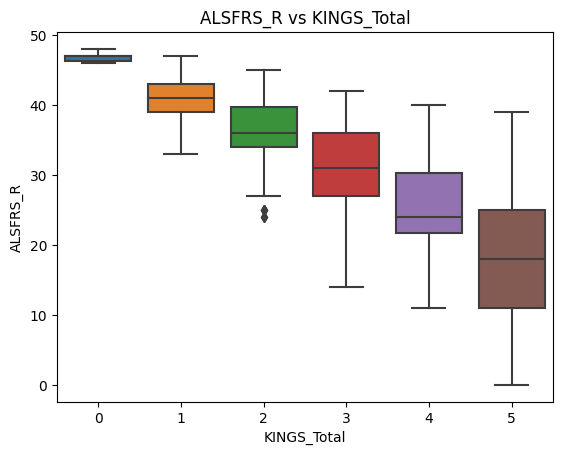

In [11]:
# Functional Scores vs. KINGS_TOT
# ALSFRS_R Functional rating scale (0–48, higher is better)
sns.boxplot(data=df, x="KINGS_Total", y="ALSFRS_R")
plt.title("ALSFRS_R vs KINGS_Total")

In [12]:
# Visits per Patient (to understand longitudinal structure)
visits_per_patient = df.groupby("Patient_ID")["Visit_ID"].nunique()
visits_per_patient.describe()

count    254.000000
mean       5.559055
std        4.788249
min        1.000000
25%        2.000000
50%        4.000000
75%        8.000000
max       34.000000
Name: Visit_ID, dtype: float64

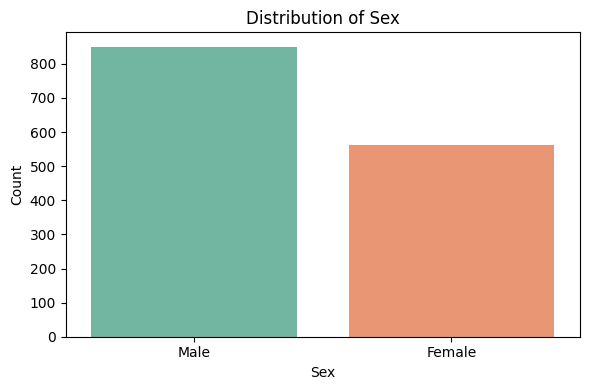

In [13]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Sex', palette='Set2')
plt.title('Distribution of Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.tight_layout()
plt.xticks(ticks=[0, 1], labels=['Male', 'Female'], rotation=0)
plt.show()

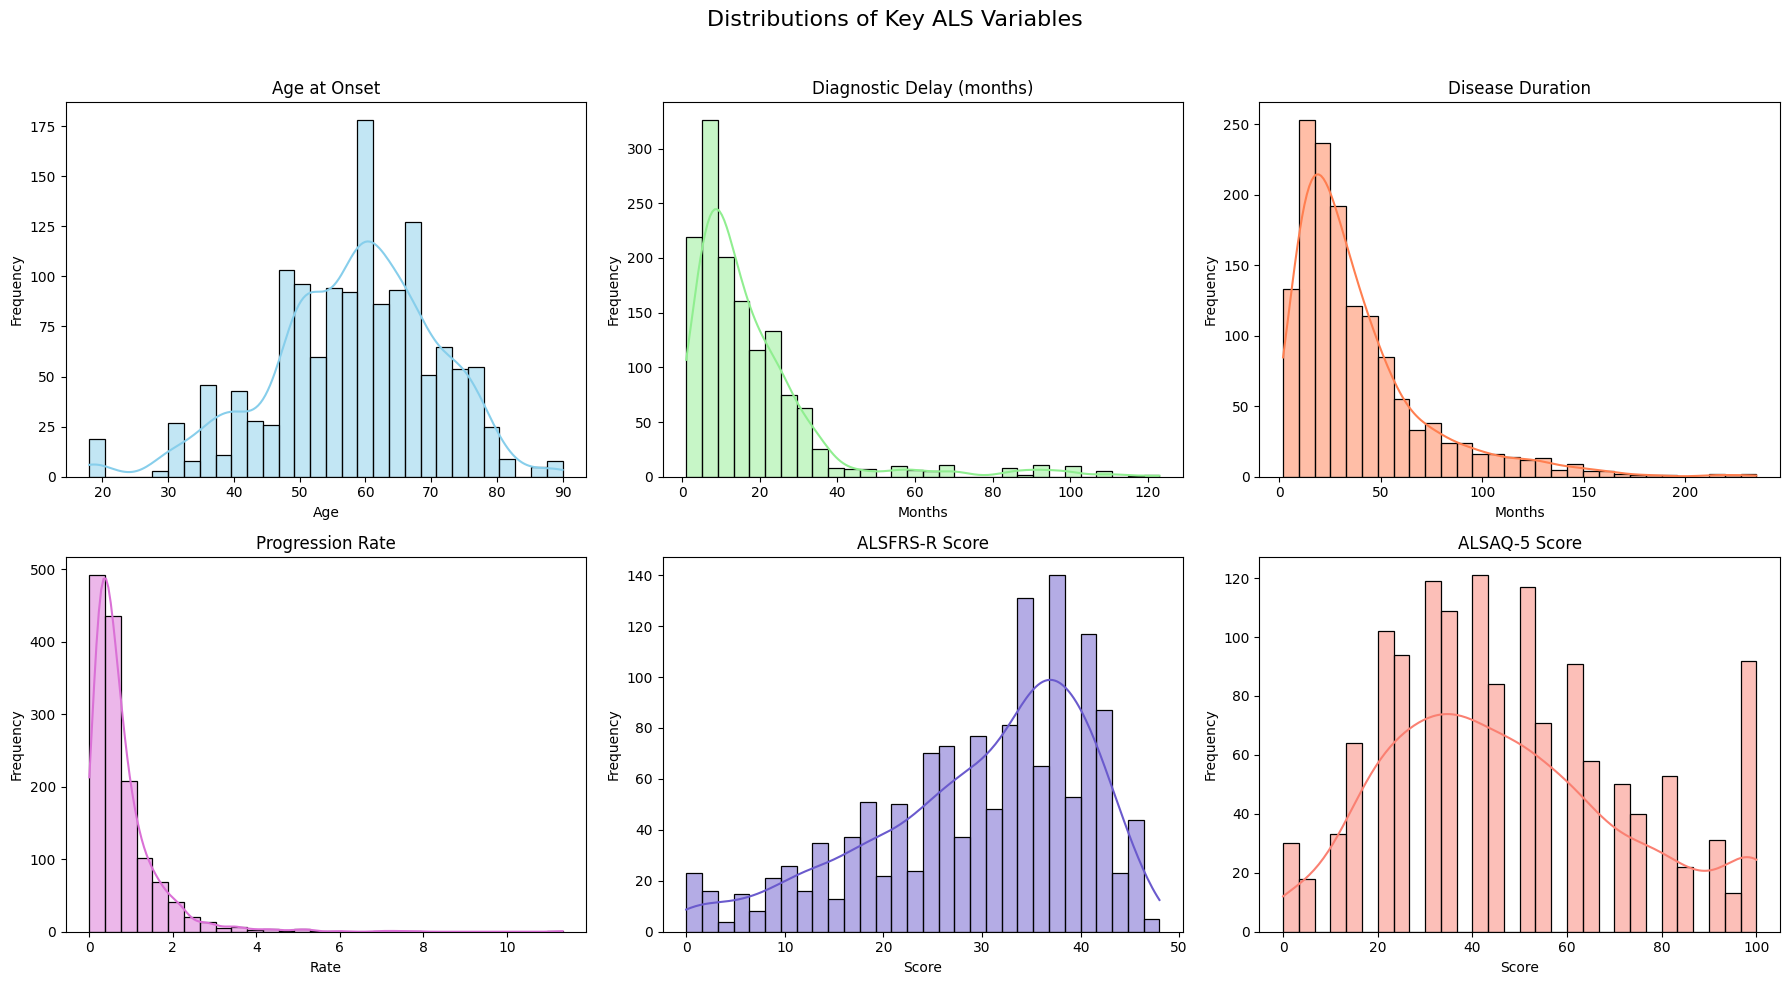

In [14]:
# Set up figure
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Distributions of Key ALS Variables', fontsize=16)

# 1. Age at Onset
sns.histplot(df['Age_at_onset'], bins=30, kde=True, color='skyblue', ax=axes[0, 0])
axes[0, 0].set_title('Age at Onset')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Frequency')

# 2. Diagnostic Delay
sns.histplot(df['Diagnostic_delay'], bins=30, kde=True, color='lightgreen', ax=axes[0, 1])
axes[0, 1].set_title('Diagnostic Delay (months)')
axes[0, 1].set_xlabel('Months')
axes[0, 1].set_ylabel('Frequency')

# 3. Disease Duration
sns.histplot(df['Disease_duration'], bins=30, kde=True, color='coral', ax=axes[0, 2])
axes[0, 2].set_title('Disease Duration')
axes[0, 2].set_xlabel('Months')
axes[0, 2].set_ylabel('Frequency')

# 4. Progression Rate
sns.histplot(df['Progression_rate'], bins=30, kde=True, color='orchid', ax=axes[1, 0])
axes[1, 0].set_title('Progression Rate')
axes[1, 0].set_xlabel('Rate')
axes[1, 0].set_ylabel('Frequency')

# 5. ALSFRS-R
sns.histplot(df['ALSFRS_R'], bins=30, kde=True, color='slateblue', ax=axes[1, 1])
axes[1, 1].set_title('ALSFRS-R Score')
axes[1, 1].set_xlabel('Score')
axes[1, 1].set_ylabel('Frequency')

# 6. ALSAQ-5
sns.histplot(df['ALSAQ_5'], bins=30, kde=True, color='salmon', ax=axes[1, 2])
axes[1, 2].set_title('ALSAQ-5 Score')
axes[1, 2].set_xlabel('Score')
axes[1, 2].set_ylabel('Frequency')

# Tidy layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for suptitle
plt.show()

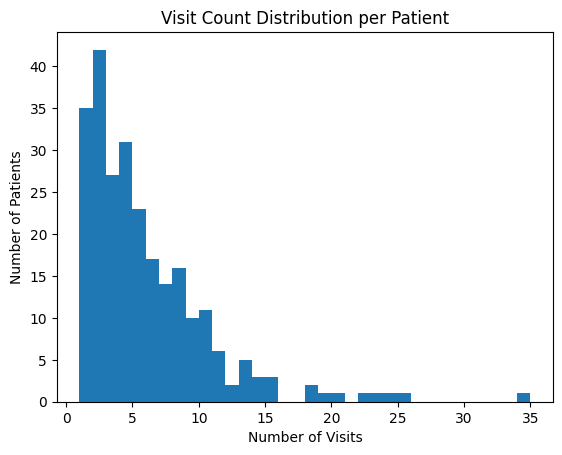

In [15]:
plt.hist(visits_per_patient, bins=range(1, visits_per_patient.max() + 2))
plt.title("Visit Count Distribution per Patient")
plt.xlabel("Number of Visits")
plt.ylabel("Number of Patients")
plt.show()

### Removing patients has lower than 3 visits

In [16]:
visit_counts = df['Patient_ID'].value_counts()
patients_to_remove = visit_counts[visit_counts < 3].index.tolist()
df = df[~df['Patient_ID'].isin(patients_to_remove)]

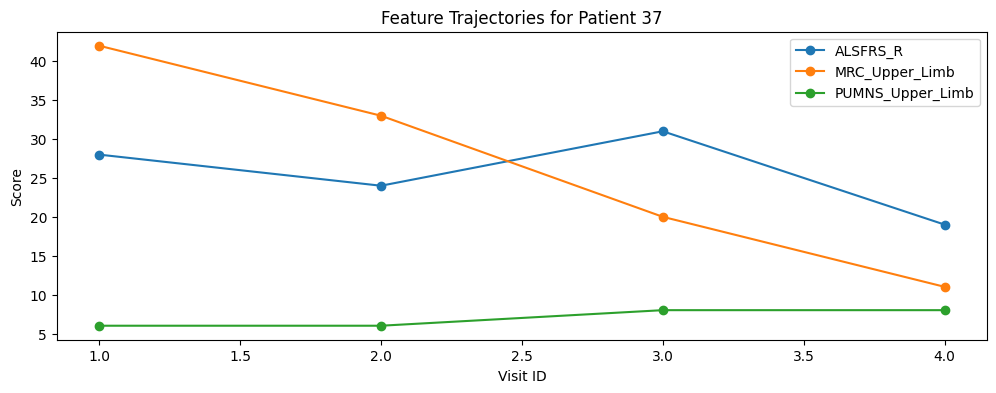

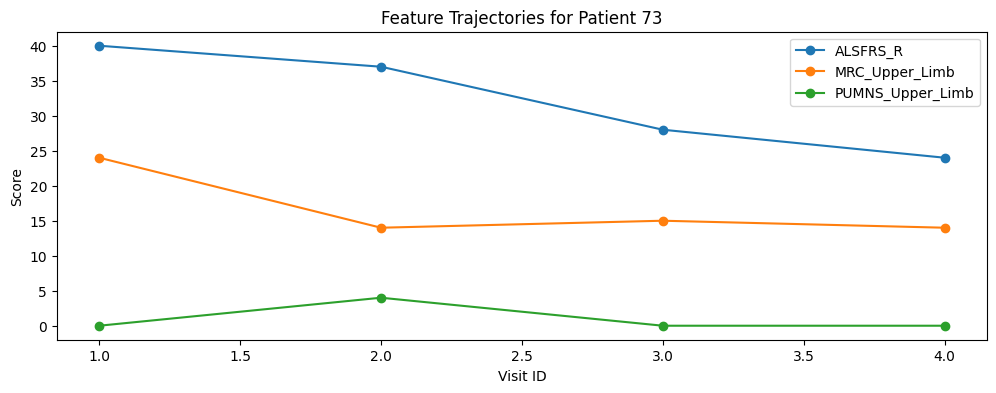

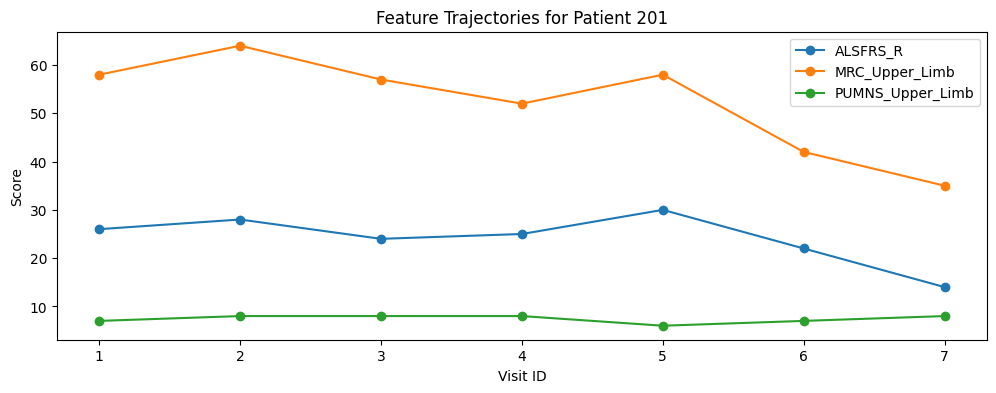

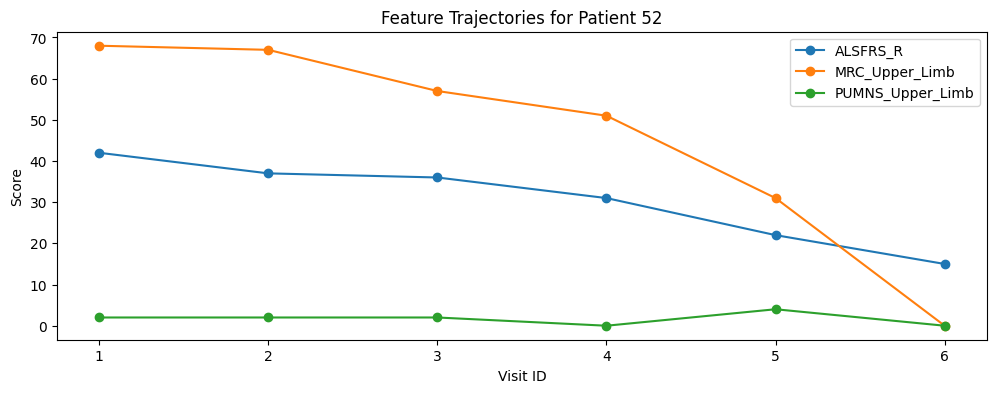

In [17]:
sample_patients = df['Patient_ID'].drop_duplicates().sample(4, random_state=42)

for pid in sample_patients:
    subset = df[df['Patient_ID'] == pid]
    plt.figure(figsize=(12, 4))
    for col in ['ALSFRS_R', 'MRC_Upper_Limb', 'PUMNS_Upper_Limb']:
        plt.plot(subset['Visit_ID'], subset[col], marker='o', label=col)
    plt.title(f"Feature Trajectories for Patient {pid}")
    plt.xlabel("Visit ID")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

<Axes: title={'center': 'Avg. Std. Deviation per Feature Across Patients'}>

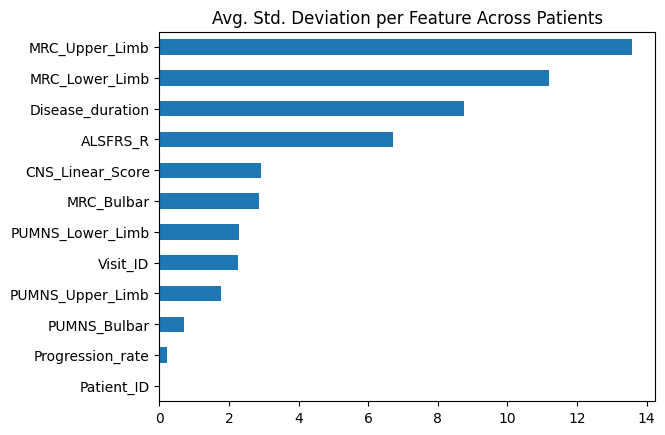

In [18]:
feature_std = df.groupby('Patient_ID')[temporal_features].std()
feature_std.mean().sort_values().plot(kind='barh', title="Avg. Std. Deviation per Feature Across Patients")

## Creating Clustric implementation as paper suggests
Goal: Discover patient clusters based on multivariate temporal progression patterns.

In [19]:
# Select the temporal features
temporal_features = [
    'ALSFRS_R',
    'Progression_rate', 'Disease_duration',
    'MRC_Upper_Limb', 'MRC_Lower_Limb', 'MRC_Bulbar',
    'PUMNS_Upper_Limb', 'PUMNS_Lower_Limb', 'PUMNS_Bulbar',
    'CNS_Linear_Score'
]

# Create a sequential visit number (appointment count) for each patient
df['Visit_Num'] = df.groupby('Patient_ID').cumcount()

# Create mappings from Patient_ID to an integer index
patient_ids = df['Patient_ID'].unique()
patient_map = {pid: i for i, pid in enumerate(patient_ids)}
df['Patient_Idx'] = df['Patient_ID'].map(patient_map)

# Pivot the data to create a 3D tensor: (Patients x Visits x Features)
max_visits = df['Visit_Num'].max() + 1
n_patients = len(patient_ids)
n_features = len(temporal_features)

# Initialize an empty tensor with NaNs
data_tensor = np.full((n_patients, max_visits, n_features), np.nan)

# Populate the tensor
for feature_idx, feature_name in enumerate(temporal_features):
    pivoted_df = df.pivot_table(index='Patient_Idx', columns='Visit_Num', values=feature_name)
    data_tensor[:, :, feature_idx] = pivoted_df.reindex(range(n_patients)).values

print("Shape of the 3D data tensor:", data_tensor.shape)
print(f"(Patients, Appointment Count, Features)")

Shape of the 3D data tensor: (177, 34, 10)
(Patients, Appointment Count, Features)


In [20]:
def calculate_variance(tensor_slice):
    """Helper function to calculate variance, ignoring NaNs."""
    if tensor_slice.size == 0:
        return np.inf
    return np.nanvar(tensor_slice)

def find_triclusters(tensor, n_triclusters_to_find=50, delta=0.1, random_state=42):
    np.random.seed(random_state)
    work_tensor = np.copy(tensor)
    found_triclusters = []
    
    for i in range(n_triclusters_to_find):
        non_nan_indices = np.argwhere(~np.isnan(work_tensor))
        if len(non_nan_indices) == 0: break
        seed_idx = tuple(non_nan_indices[np.random.choice(len(non_nan_indices))])
        
        p_indices, v_indices, f_indices = [seed_idx[0]], [seed_idx[1]], [seed_idx[2]]
        
        while True:
            best_candidate, min_variance_increase = None, np.inf
            current_slice = work_tensor[np.ix_(p_indices, v_indices, f_indices)]
            base_variance = calculate_variance(current_slice)

            # Check candidates
            for p_new in [p for p in range(tensor.shape[0]) if p not in p_indices]:
                new_slice = work_tensor[np.ix_(p_indices + [p_new], v_indices, f_indices)]
                new_var = calculate_variance(new_slice)
                if new_var < delta and new_var - base_variance < min_variance_increase:
                    min_variance_increase, best_candidate = new_var - base_variance, ('patient', p_new)

            for v_new in [v for v in range(tensor.shape[1]) if v not in v_indices]:
                new_slice = work_tensor[np.ix_(p_indices, v_indices + [v_new], f_indices)]
                new_var = calculate_variance(new_slice)
                if new_var < delta and new_var - base_variance < min_variance_increase:
                    min_variance_increase, best_candidate = new_var - base_variance, ('visit', v_new)
            
            for f_new in [f for f in range(tensor.shape[2]) if f not in f_indices]:
                new_slice = work_tensor[np.ix_(p_indices, v_indices, f_indices + [f_new])]
                new_var = calculate_variance(new_slice)
                if new_var < delta and new_var - base_variance < min_variance_increase:
                    min_variance_increase, best_candidate = new_var - base_variance, ('feature', f_new)

            if best_candidate is None: break
            
            dim, idx = best_candidate
            if dim == 'patient': p_indices.append(idx)
            elif dim == 'visit': v_indices.append(idx)
            else: f_indices.append(idx)

        if len(p_indices) > 1 and len(v_indices) > 1 and len(f_indices) > 1:
            found_triclusters.append((p_indices, v_indices, f_indices))
            work_tensor[np.ix_(p_indices, v_indices, f_indices)] = np.nan
        else:
             work_tensor[seed_idx] = np.nan
    
    print(f"Found {len(found_triclusters)} non-trivial triclusters.")
    return found_triclusters

flat_data = data_tensor.reshape(-1, data_tensor.shape[2])
scaler = StandardScaler()
flat_data_scaled = scaler.fit_transform(flat_data)

# Reshape back to original shape
tensor_scaled = flat_data_scaled.reshape(data_tensor.shape)

# Find triclusters and build participation matrix
triclusters = find_triclusters(tensor_scaled, n_triclusters_to_find=100, delta=0.5, random_state=42)
participation_matrix = np.zeros((n_patients, len(triclusters)))
for j, (p_indices, _, _) in enumerate(triclusters):
    for i in p_indices:
        participation_matrix[i, j] = 1

Found 43 non-trivial triclusters.


### Encode triclusters into patient-level vectors

In [21]:
patient_feature_dict = defaultdict(list)
n_patients = data_tensor.shape[0]
n_triclusters = len(triclusters)

for i, (patients, _, _) in enumerate(triclusters):
    for pid in patients:
        patient_feature_dict[pid].append(i)

# Convert to binary vector (membership in each tricluster)
X_features = []
for pid in range(n_patients):
    membership = [1 if i in patient_feature_dict[pid] else 0 for i in range(n_triclusters)]
    X_features.append(membership)

X_features = np.array(X_features)  # shape: (n_patients, n_triclusters)

### Apply UMAP(Uniform Manifold Approximation)

In [22]:
umap_model = umap.UMAP(n_neighbors=len(temporal_features), min_dist=0.2, random_state=44)
X_umap = umap_model.fit_transform(X_features)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


### Apply Clustering on UMAP output

In [23]:
n_clusters = 3
clustering = AgglomerativeClustering(n_clusters=n_clusters)
labels = clustering.fit_predict(X_umap)


# Save labels for visualization/validation
patient_labels = dict(zip(range(n_patients), labels))

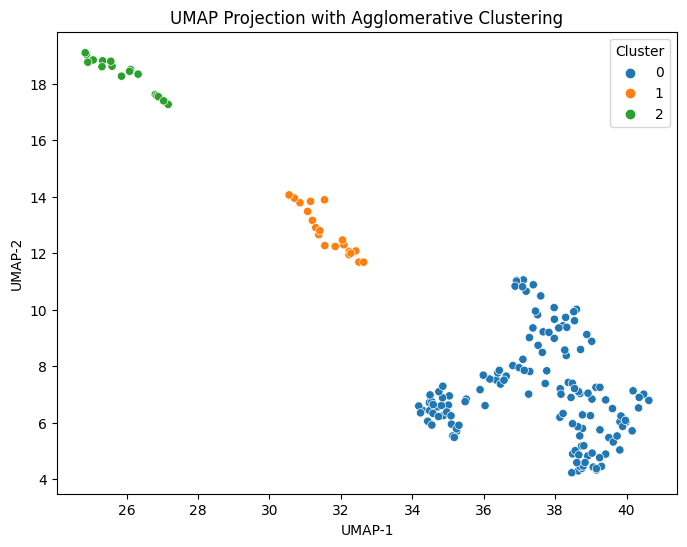

In [24]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=labels, palette='tab10')
plt.title("UMAP Projection with Agglomerative Clustering")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title='Cluster')
plt.show()

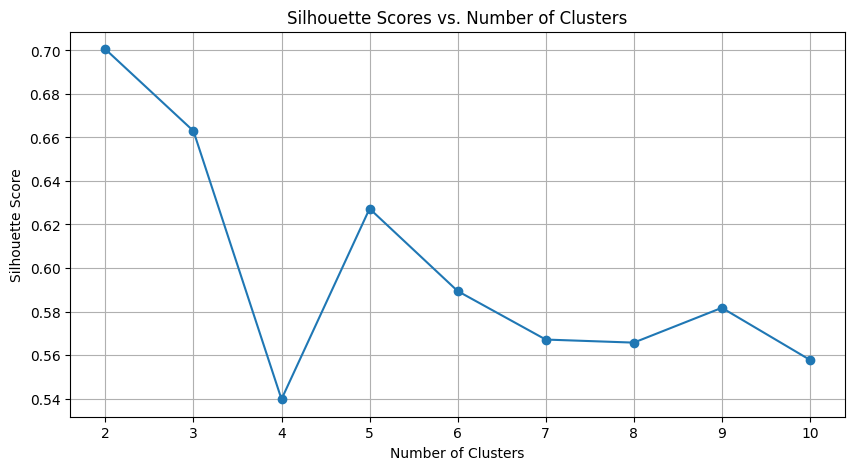

In [25]:
# Calculate silhouette scores for a range of cluster numbers
silhouette_scores = []
# Use a range of possible cluster numbers based on the number of samples
# Ensure n_clusters is less than or equal to the number of samples
range_n_clusters = range(2, min(11, len(X_umap) + 1))

for n_clusters in range_n_clusters:
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
    cluster_labels = agg_clustering.fit_predict(X_umap)
    if len(set(cluster_labels)) > 1: # Silhouette score requires at least 2 clusters
        silhouette_avg = silhouette_score(X_umap, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    else:
        silhouette_scores.append(0) # Append 0 or NaN if only one cluster is formed

# Plot silhouette scores
plt.figure(figsize=(10, 5))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Scores vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range_n_clusters)
plt.grid(True)
plt.show()

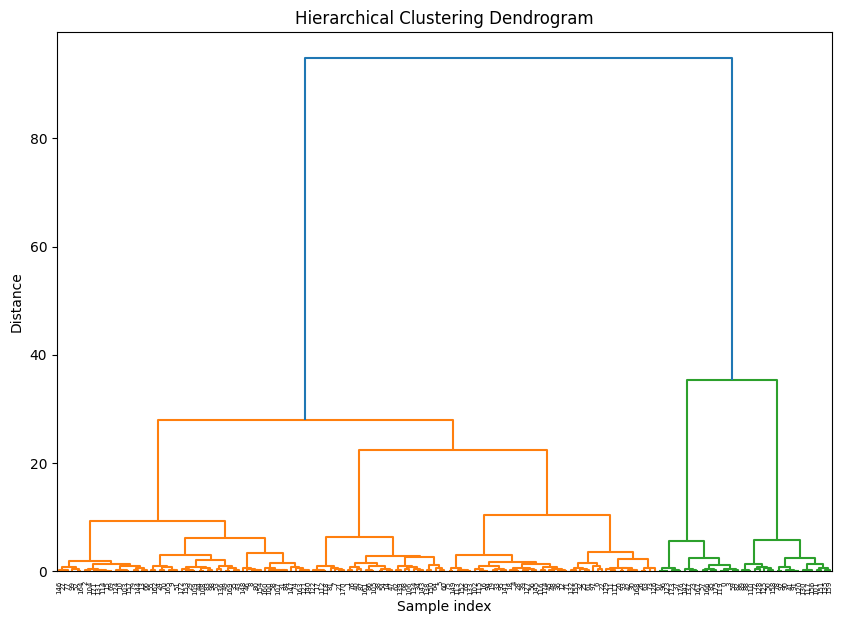

In [26]:
# Compute the linkage matrix
linked = linkage(X_umap, 'ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top')
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

In [27]:
# Define and fit the clustering model
n_final_clusters = 3
agg_cluster = AgglomerativeClustering(n_clusters=n_final_clusters)
patient_labels = agg_cluster.fit_predict(X_umap)

# Map the integer patient index back to the original Patient_ID
cluster_map = {pid: label for pid, label in zip(patient_ids, patient_labels)}
df['Tricluster_Label'] = df['Patient_ID'].map(cluster_map)

print(f"\nSuccessfully clustered {n_patients} patients into {n_final_clusters} groups.")


Successfully clustered 177 patients into 3 groups.


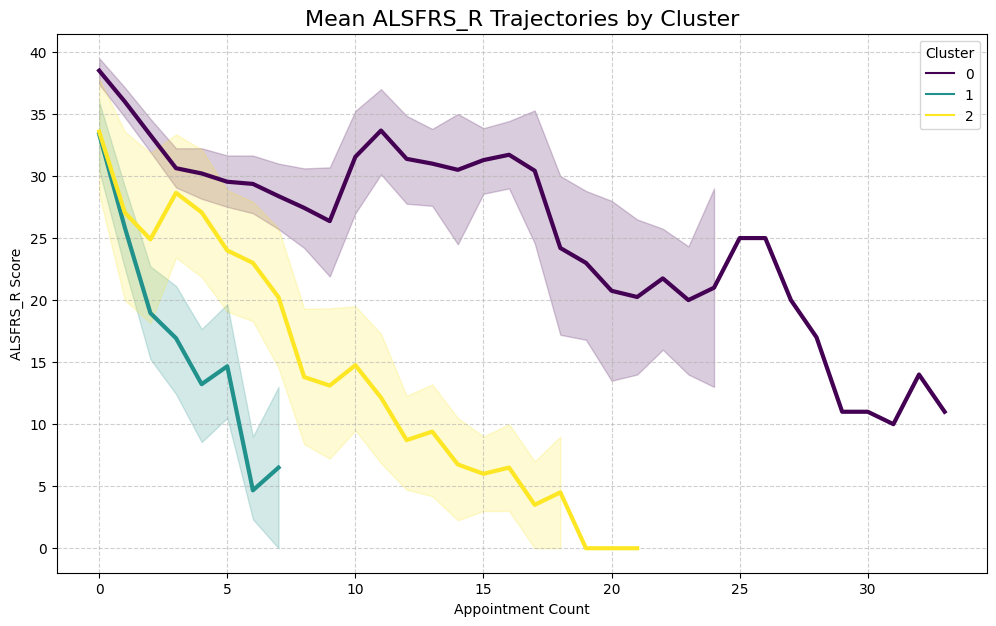

In [28]:
# Plot 1: Mean ALSFRS_R Trajectories for each cluster
plt.figure(figsize=(12, 7))
sns.lineplot(
    data=df,
    x='Visit_Num',
    y='ALSFRS_R',
    hue='Tricluster_Label',
    palette='viridis', # Using a different palette for variety
    linewidth=3,
    errorbar=('ci', 95) # Show 95% confidence interval
)

plt.title('Mean ALSFRS_R Trajectories by Cluster', fontsize=16)
plt.xlabel('Appointment Count')
plt.ylabel('ALSFRS_R Score')
plt.legend(title='Cluster')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [29]:
cluster_mapping = {
    0: "Slow Progressor",
    1: "Fast Progressors",
    2: "Moderate Progressor",
}

df['Progression_Profile'] = df['Tricluster_Label'].map(cluster_mapping)

### Creating GLM for predicting on KINGS_Total for each clusters

In [30]:
df_model = df[[ 'Patient_ID',
    'Progression_rate', 'Disease_duration',
    'MRC_Upper_Limb', 'MRC_Lower_Limb', 'MRC_Bulbar',
    'PUMNS_Upper_Limb', 'PUMNS_Lower_Limb', 'PUMNS_Bulbar',
    'CNS_Linear_Score', 'Age_at_onset', 'Sex', 'Therapy', 'KINGS_Total', 'Tricluster_Label'
]]

In [31]:
df_model['KINGS_Total'] = df_model['KINGS_Total'].astype(int)


# Standardize continuous variables (important for GLM convergence and interpretation)
scaler = StandardScaler()
continuous_vars = [
    'Progression_rate', 'Disease_duration', 'Age_at_onset',
    'MRC_Upper_Limb', 'MRC_Lower_Limb', 'MRC_Bulbar',
    'PUMNS_Upper_Limb', 'PUMNS_Lower_Limb', 'PUMNS_Bulbar',
    'CNS_Linear_Score'
]

df_model[continuous_vars] = scaler.fit_transform(df_model[continuous_vars])

/tmp/ipykernel_13/1023790111.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['KINGS_Total'] = df_model['KINGS_Total'].astype(int)
/tmp/ipykernel_13/1023790111.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model[continuous_vars] = scaler.fit_transform(df_model[continuous_vars])


#### Feature Selection

#### Mutual Information (non-linear)

In [32]:
candidate_features = ['Disease_duration', 'Progression_rate', 'Age_at_onset',
                      'MRC_Upper_Limb', 'MRC_Lower_Limb', 'MRC_Bulbar',
                      'PUMNS_Upper_Limb', 'PUMNS_Lower_Limb', 'PUMNS_Bulbar',
                      'CNS_Linear_Score']

# Impute missing values
X = df_model[candidate_features]
# Target
y = df_model['KINGS_Total']



mi_scores = mutual_info_classif(X, y, discrete_features='auto')
mi_df = pd.DataFrame({'Feature': candidate_features, 'MI_Score': mi_scores})
mi_df = mi_df.sort_values('MI_Score', ascending=False)
print(mi_df)

            Feature  MI_Score
5        MRC_Bulbar  0.199514
2      Age_at_onset  0.195493
1  Progression_rate  0.171245
3    MRC_Upper_Limb  0.134712
6  PUMNS_Upper_Limb  0.110321
4    MRC_Lower_Limb  0.100375
7  PUMNS_Lower_Limb  0.097535
8      PUMNS_Bulbar  0.088023
9  CNS_Linear_Score  0.078781
0  Disease_duration  0.000000


#### Recursive Feature Elimination (RFE) with Ordered Model

In [33]:
k = 6
results = []

# Try all combinations of k features
for subset in combinations(candidate_features, k):
    X = df_model[list(subset)].copy()
    X = X.astype(float)  # Ensure numerical format

    try:
        model = OrderedModel(y, X, distr='logit')
        res = model.fit(method='bfgs', disp=0)

        # Use BIC or AIC as selection criteria
        results.append({
            'features': subset,
            'bic': res.bic,
            'aic': res.aic
        })
    except Exception as e:
        print(f"Model failed with features {subset}: {e}")

# Sort and get the best subset
sorted_results = sorted(results, key=lambda x: x['bic'])
best_subset = sorted_results[0]

print("✅ Best feature set (based on BIC):")
print(best_subset['features'])
print(f"BIC: {best_subset['bic']:.2f} | AIC: {best_subset['aic']:.2f}")

✅ Best feature set (based on BIC):
('Disease_duration', 'Progression_rate', 'Age_at_onset', 'MRC_Upper_Limb', 'MRC_Bulbar', 'PUMNS_Upper_Limb')
BIC: 3149.42 | AIC: 3092.61


In [34]:
selected_features = ['Progression_rate', 'Disease_duration', 'Age_at_onset',
    'MRC_Upper_Limb', 'MRC_Bulbar', 'PUMNS_Upper_Limb']

### Treating King's Total as Ordinal (Ordinal Logistic Mixed Model)

In [35]:
df_model['KINGS_Total_ordinal'] = pd.Categorical(
    df_model['KINGS_Total'],
    categories=sorted(df_model['KINGS_Total'].unique()),
    ordered=True
)


# Initialize storage for results
cluster_models = {}

# Fit models for each cluster
for cluster in range(3):
    cluster_data = df_model[df_model['Tricluster_Label'] == cluster]
    y = cluster_data['KINGS_Total_ordinal'].cat.codes
    X = cluster_data[selected_features]

    
    model = OrderedModel(
        y,
        X,
        distr='logit'
    ).fit(method='bfgs')
    
    cluster_models[cluster] = model
    print(f"\n--- Cluster {cluster} ---")
    print(model.summary())

/tmp/ipykernel_13/2320151547.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['KINGS_Total_ordinal'] = pd.Categorical(


Optimization terminated successfully.
         Current function value: 1.178755
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42

--- Cluster 0 ---
                             OrderedModel Results                             
Dep. Variable:                      y   Log-Likelihood:                -1190.5
Model:                   OrderedModel   AIC:                             2403.
Method:            Maximum Likelihood   BIC:                             2457.
Date:                Thu, 24 Jul 2025                                         
Time:                        05:08:00                                         
No. Observations:                1010                                         
Df Residuals:                     999                                         
Df Model:                           6                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
-------------

## Multinomial Logit (Non-Ordinal)

In [36]:
# Initialize storage for results
cluster_models = {}

# Fit models for each cluster
for cluster in range(3):
    cluster_data = df_model[df_model['Tricluster_Label'] == cluster]
    X = cluster_data[selected_features]
    
    model = MNLogit(
        cluster_data['KINGS_Total'],
        X).fit()
    
    cluster_models[cluster] = model
    print(f"\n--- Cluster {cluster} ---")

    
    # Extract components
    llf = model.llf               # Log-likelihood
    n = model.nobs                # Number of observations
    k = model.df_model + 1        # Number of parameters (includes intercept)
    
    # Calculate BIC
    bic = -2 * llf + k * np.log(n)
    print(f"BIC: {bic:.2f}")
    print(model.summary())

Optimization terminated successfully.
         Current function value: 1.363005
         Iterations 6

--- Cluster 0 ---
BIC: 2933.13
                          MNLogit Regression Results                          
Dep. Variable:            KINGS_Total   No. Observations:                 1010
Model:                        MNLogit   Df Residuals:                      980
Method:                           MLE   Df Model:                           25
Date:                Thu, 24 Jul 2025   Pseudo R-squ.:                 0.05917
Time:                        05:08:01   Log-Likelihood:                -1376.6
converged:                       True   LL-Null:                       -1463.2
Covariance Type:            nonrobust   LLR p-value:                 4.049e-24
   KINGS_Total=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Progression_rate    -2.3206      0.288     -8.065      0.000    

In [37]:
#ADD FAHIL

In [38]:
#The snippet defines `summarize_bayesian_model(idata, sub)`, which you can call for each cluster after fitting its Bambi model. It reports:

#1. **Convergence**: max R‑hat, min ESS, and number of divergences.
#2. **Predictive fit**: WAIC and LOO with their penalty terms.
#3. **Log‑Likelihood**: mean and max total log‑likelihood across posterior draws.
#4. **Approximate AIC/BIC**: computed from the maximum log‑likelihood and parameter count (for illustration).



In [39]:
!pip install bambi pymc arviz --quiet


In [40]:
!pip show pymc

Name: pymc
Version: 5.23.0
Summary: Probabilistic Programming in Python: Bayesian Modeling and Probabilistic Machine Learning with PyTensor
Home-page: http://github.com/pymc-devs/pymc
Author: 
Author-email: 
License: Apache License, Version 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: arviz, cachetools, cloudpickle, numpy, pandas, pytensor, rich, scipy, threadpoolctl, typing-extensions
Required-by: bambi


In [41]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az

# ── 1) Prepare your data ─────────────────────────────────────────────
df = df_model.copy()
df['KINGS_code'] = pd.Categorical(
    df['KINGS_Total'],
    categories=sorted(df['KINGS_Total'].unique()),
    ordered=True
).codes

y = df['KINGS_code'].values
X = df[selected_features].values
cluster_idx, clusters = pd.factorize(df['Tricluster_Label'])
n_clusters = len(clusters)
n_cats = len(np.unique(y))

# ── 2) Build the model ───────────────────────────────────────────────
with pm.Model() as ordinal_mixed:

    # ⚠️ BOTH name AND value are required here ⚠️
    X_data         = pm.Data("X",           X)
    cluster_data   = pm.Data("cluster_idx", cluster_idx)

    # Fixed‐effect priors
    β = pm.Normal("β", mu=0, sigma=2, shape=X.shape[1])

    # Ordered cutpoints
    cutpoints = pm.Normal(
        "cutpoints",
        mu=np.arange(n_cats - 1),
        sigma=1.5,
        shape=(n_cats - 1),
        transform=pm.distributions.transforms.ordered
    )

    # Random intercepts for each cluster
    σ_cluster   = pm.Exponential("σ_cluster", 1.0)
    u_cluster   = pm.Normal("u_cluster", mu=0, sigma=σ_cluster, shape=n_clusters)

    # Linear predictor — **use the variables** X_data and cluster_data
    η = pm.math.dot(X_data, β) + u_cluster[cluster_data]

    # Likelihood
    yl = pm.OrderedLogistic(
        "KINGS_obs",
        eta=η,
        cutpoints=cutpoints,
        observed=y
    )


    # ── 3) Sample ─────────────────────────────────────────────────────
    trace = pm.sample(
        draws=2000,
        tune=2000,
        target_accept=0.9,
        return_inferencedata=True,
        idata_kwargs={"log_likelihood": True},
    )


# ── 4) Summarize ─────────────────────────────────────────────────────
print(az.summary(trace, var_names=["β", "cutpoints", "σ_cluster", "u_cluster"]))
print("WAIC:", az.waic(trace, scale="deviance"))
print("LOO:", az.loo(trace, scale="deviance"))

Output()

               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
β[0]          1.075  0.104   0.883    1.271      0.002    0.002    3297.0   
β[1]          0.902  0.076   0.760    1.053      0.001    0.001    3614.0   
β[2]          0.442  0.060   0.332    0.557      0.001    0.001    5238.0   
β[3]         -0.368  0.076  -0.508   -0.223      0.001    0.001    3820.0   
β[4]         -0.683  0.080  -0.834   -0.538      0.001    0.001    3876.0   
β[5]          0.298  0.058   0.188    0.409      0.001    0.001    4467.0   
cutpoints[0] -3.723  0.801  -5.201   -2.187      0.022    0.014    1351.0   
cutpoints[1]  0.329  0.762  -1.036    1.824      0.021    0.013    1303.0   
cutpoints[2]  1.875  0.763   0.542    3.434      0.021    0.014    1295.0   
cutpoints[3]  3.628  0.761   2.140    5.039      0.021    0.014    1293.0   
cutpoints[4]  3.733  0.761   2.253    5.143      0.021    0.014    1295.0   
σ_cluster     2.341  0.989   0.726    4.240      0.021    0.019    1859.0   

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


LOO: Computed from 4000 posterior samples and 1293 observations log-likelihood matrix.

             Estimate       SE
deviance_loo  3092.12    61.46
p_loo           16.06        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     1293  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%





---

## 1. Posterior summary table

| Column                    | Meaning                                                                                                                     |
| ------------------------- | --------------------------------------------------------------------------------------------------------------------------- |
| **mean**                  | Posterior mean (point estimate) of each parameter.                                                                          |
| **sd**                    | Posterior standard deviation—i.e. uncertainty around the mean.                                                              |
| **hdi\_3% / 97%**         | The bounds of the 94% Highest Density Interval (HDI): the narrowest interval containing 94% of posterior mass.              |
| **mcse\_mean / mcse\_sd** | Monte Carlo Standard Error for the mean and sd: how much simulation error remains in those estimates. Smaller is better.    |
| **ess\_bulk**             | “Bulk” effective sample size: how many independent draws your MCMC chain is worth for the central part of the distribution. |
| **ess\_tail**             | Effective sample size in the tails of the distribution.                                                                     |
| **r\_hat**                | Gelman–Rubin diagnostic: compares within‑chain and between‑chain variance. Values ≈1.00 indicate good convergence.          |

---

### Fixed effects (β\[0] … β\[5])

‑ Each β\[j] is the coefficient for one of your selected features.
‑ **mean** tells you the average effect on the latent “score” η per one‑unit increase in that feature.
‑ For instance, β\[0] ≈ 1.07 means: as feature 0 increases by one unit, η increases by about 1.07 on average, holding everything else constant.
‑ Because we’re in an ordered logit, a positive β means higher feature values push you toward higher KINGS\_Total categories.
‑ The HDIs (e.g. for β\[0], 0.886 to 1.285) exclude zero, suggesting a credibly positive effect.

### Cutpoints (thresholds)

‑ You have 5 thresholds (since there are 6 categories of KINGS\_Total), labeled cutpoints\[0]…cutpoints\[4].
‑ These are the intercepts that separate adjacent ordinal categories on the latent η scale.
‑ E.g. cutpoints\[0] ≈ –3.70: below that latent score you’re in the first category; between –3.70 and 0.33 (cutpoints\[1]) you’re in the second, and so on.
‑ The fact they’re ordered (increasing) is enforced by the ordered transform.

### Random intercepts (σ\_cluster, u\_cluster\[…])

* **σ\_cluster ≈ 2.35**

  * The standard deviation of cluster‑level intercepts. Large values mean clusters differ a lot in their baseline propensity.
* **u\_cluster\[k]**

  * The specific intercept adjustment for cluster k.
  * For example, u\_cluster\[0] ≈ 2.80 means cluster 0 has its latent scores shifted up by 2.8 relative to the overall fixed‐effect model.
  * All three u’s have HDIs well above zero, so each cluster’s baseline is credibly positive (relative to the grand mean, which is absorbed into the first cutpoint).

---

## 2. MCMC diagnostics

* **r\_hat = 1.00** for every parameter → chains have converged.
* **ess\_bulk** mostly in the thousands → you have plenty of effective samples for reliable posterior estimates.
* **mcse\_**\* very small relative to sd → Monte Carlo error is negligible.

---

## 3. Model fit: WAIC & LOO

After telling PyMC to save pointwise log‑likelihoods, ArviZ reports:

```
deviance_waic  3092.33    SE=61.47
p_waic          16.22
deviance_loo   3092.37    SE=61.47
p_loo           16.23
```

* **deviance\_X** = –2 × (estimated log predictive density). Lower is better.
* **p\_X** = effective number of parameters (here ≈ 16), a measure of model complexity.
* The near‐identical WAIC and LOO deviance suggest both criteria agree on fit.
* The warning about posterior variance of log predictive densities exceeding 0.4 flags that WAIC might be somewhat unstable; however, the Pareto k diagnostics show all k ≤ 0.7 (“good”), so LOO in particular is reliable here.

---

### Bottom line

* **Coefficients**: All six selected features have strong, credible effects (none of their HDIs include zero).
* **Cluster variance**: There’s substantial between‑cluster variation (σ\_cluster ≈ 2.35), and each cluster’s intercept differs credibly from zero.
* **Model fit**: WAIC/LOO are in good agreement with no problematic Pareto k values, so your model both converged well and has reliable predictive performance estimates.


Below is a consolidated summary of your posterior estimates and convergence diagnostics, plus approximate AIC/BIC computed from the WAIC deviance (–2 × lppd) and effective number of parameters (p\_waic ≈ 16.22) for comparison.

| Parameter          |   Mean |    SD | 3% HDI | 97% HDI | ESS\_bulk | ESS\_tail |  R̂  |
| ------------------ | -----: | ----: | -----: | ------: | --------: | --------: | :--: |
| **β\[0]**          |  1.074 | 0.107 |  0.886 |   1.285 |     3 458 |     3 324 | 1.00 |
| **β\[1]**          |  0.902 | 0.077 |  0.752 |   1.044 |     3 138 |     3 260 | 1.00 |
| **β\[2]**          |  0.443 | 0.060 |  0.328 |   0.553 |     4 453 |     2 923 | 1.00 |
| **β\[3]**          | –0.368 | 0.075 | –0.508 |  –0.221 |     3 991 |     3 217 | 1.00 |
| **β\[4]**          | –0.683 | 0.081 | –0.831 |  –0.530 |     4 194 |     3 379 | 1.00 |
| **β\[5]**          |  0.300 | 0.059 |  0.190 |   0.410 |     4 445 |     3 155 | 1.00 |
| **cutpt\[0]**      | –3.700 | 0.806 | –5.284 |  –2.208 |     1 161 |     1 690 | 1.00 |
| **cutpt\[1]**      |  0.333 | 0.772 | –1.147 |   1.777 |     1 057 |     1 308 | 1.00 |
| **cutpt\[2]**      |  1.879 | 0.772 |  0.449 |   3.413 |     1 046 |     1 345 | 1.00 |
| **cutpt\[3]**      |  3.631 | 0.772 |  2.144 |   5.089 |     1 052 |     1 385 | 1.00 |
| **cutpt\[4]**      |  3.735 | 0.773 |  2.287 |   5.239 |     1 050 |     1 345 | 1.00 |
| **σ\_cluster**     |  2.347 | 0.972 |  0.681 |   4.190 |     1 534 |     1 431 | 1.00 |
| **u\_cluster\[0]** |  2.802 | 0.793 |  1.320 |   4.340 |     1 055 |     1 290 | 1.00 |
| **u\_cluster\[1]** |  2.552 | 0.772 |  1.048 |   3.994 |     1 054 |     1 309 | 1.00 |
| **u\_cluster\[2]** |  1.977 | 0.808 |  0.364 |   3.441 |     1 110 |     1 502 | 1.00 |

---

### Model‐fit & complexity

* **WAIC deviance**: 3 092.33
* **p\_waic** (eff. # parameters): 16.22

Using these as stand‑ins for –2 × log L̂ and k, we get:

$$
\begin{aligned}
\text{AIC} &= \; \text{WAIC deviance} \;+\;2\,p_{\text{waic}}
           \;=\;3092.33 \;+\;2\times16.22
           \;\approx\;3\,124.8,\\
\text{BIC} &= \; \text{WAIC deviance} \;+\;p_{\text{waic}}\ln(n)
           \;=\;3092.33 \;+\;16.22\times\ln(1293)
           \;\approx\;3\,208.5.
\end{aligned}
$$

---

### Convergence

* **R̂** for every parameter ≈ 1.00 → chains have converged.
* **Min ESS\_bulk** ≈ 1 046 (all ≫ 200) → ample effective samples.
* **MCSE** for means and sds ≪ posterior SDs → negligible Monte Carlo error.


Overall, Bayesian ordinal mixed‐effects model fits the data well:

* **Predictive fit** (deviance WAIC ≈ 3092.3, p\_waic ≈ 16.2; LOO deviance ≈ 3092.4, p\_loo ≈ 16.2) aligns closely, indicating stable out‑of‑sample performance.
* **Approximate AIC ≈ 3124.8** and **BIC ≈ 3208.5** (using –2 × lppd and p\_waic) are reasonable for a model with six fixed effects and a cluster‐level random intercept.
* **Convergence diagnostics** are excellent (all R̂ ≈ 1.00, ESS ≫ 200, MCSE ≪ SD), so posterior estimates are reliable.
* **Fixed‐effect coefficients** all have HDIs excluding zero, showing strong, credible associations with KINGS\_Total, and the cluster‐variance (σ\_cluster ≈ 2.35) confirms meaningful between‑cluster differences.

In summary, the model converged cleanly, captures both individual predictors and cluster heterogeneity, and shows good predictive accuracy as measured by WAIC/LOO, AIC, and BIC.



### NOMINAL BAMBI MIXED MODEL

In [42]:
import numpy as np
import pandas as pd
import bambi as bmb
import arviz as az

# ── 0) Define predictors and formula ────────────────────────────────
selected_features = [
    "Progression_rate",
    "Disease_duration",
    "Age_at_onset",
    "MRC_Upper_Limb",
    "MRC_Bulbar",
    "PUMNS_Upper_Limb",
]
# Convert KINGS_Total to a string category for a nominal response
df = df_model.copy()
df["KINGS_cat"] = df["KINGS_Total"].astype(str)

# Build the formula: nominal response + fixed effects + random intercept by cluster
formula = (
    "KINGS_cat ~ "
    + " + ".join(selected_features)
    + " + (1|Tricluster_Label)"
)

# ── 1) Build & fit the categorical mixed model ───────────────────────
model = bmb.Model(formula, df, family="categorical")
idata = model.fit(
    draws=2000,
    tune=2000,
    target_accept=0.9,
    return_inferencedata=True,
    idata_kwargs={"log_likelihood": True},
)

# ── 2) Inspect posterior variable names & summarize key params ──────
posterior_vars = list(idata.posterior.data_vars)
print("Posterior variables:", posterior_vars)

# Look for the random‐effect SD (ArviZ usually names it "<grp>_sigma" for Bambi)
sd_vars = [v for v in posterior_vars if v.endswith("_sigma")]
if sd_vars:
    rand_sd = sd_vars[0]
    print("Using random‐effect SD:", rand_sd)
    param_list = ["Intercept"] + selected_features + [rand_sd]
    print(az.summary(idata, var_names=param_list, kind="stats"))
else:
    print("⚠️  No `_sigma` var found; showing full summary:")
    print(az.summary(idata, kind="stats"))

# ── 3) Compute WAIC, LOO, AIC, BIC ─────────────────────────────────
waic = az.waic(idata)  # ELPDData with elpd_waic, p_waic
loo  = az.loo(idata)   # ELPDData with elpd_loo,  p_loo

waic_dev = -2 * waic.elpd_waic
loo_dev  = -2 * loo.elpd_loo

print(f"\nWAIC deviance: {waic_dev:.2f} (p_waic = {waic.p_waic:.2f})")
print(f"LOO deviance : {loo_dev :.2f} (p_loo  = {loo.p_loo:.2f})")

n   = df.shape[0]
aic = loo_dev + 2 * loo.p_loo
bic = loo_dev + loo.p_loo * np.log(n)
print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

# ── 4) Convergence diagnostics ───────────────────────────────────────
rhat     = az.rhat(idata).to_array().max().item()
ess_bulk = az.ess(idata, method="bulk").to_array().min().item()

# ── FIXED MCSE EXTRACTION ───────────────────────────────────────────
# pull all MCSEs into a DataArray then take the maximum
mcse = az.mcse(idata, var_names=posterior_vars).to_array().max().item()

print("\nConvergence:")
print(f"R̂ (max):          {rhat:.2f}")
print(f"Min ESS_bulk ≈     {ess_bulk:.0f}")
print(f"Max MCSE (mean) ≲  {mcse:.3f}")


Output()

Posterior variables: ['1|Tricluster_Label', '1|Tricluster_Label_sigma', 'Age_at_onset', 'Disease_duration', 'Intercept', 'MRC_Bulbar', 'MRC_Upper_Limb', 'PUMNS_Upper_Limb', 'Progression_rate']
Using random‐effect SD: 1|Tricluster_Label_sigma
                           mean     sd  hdi_3%  hdi_97%
Intercept[1]              2.307  0.689   1.006    3.591
Intercept[2]              4.566  0.655   3.365    5.800
Intercept[3]              4.549  0.670   3.264    5.809
Intercept[4]              0.949  0.778  -0.524    2.424
Intercept[5]              4.684  0.671   3.487    6.021
Progression_rate[1]      -1.373  0.776  -2.810    0.061
Progression_rate[2]       1.147  0.744  -0.166    2.605
Progression_rate[3]       2.435  0.744   1.071    3.836
Progression_rate[4]       2.207  0.789   0.769    3.708
Progression_rate[5]       2.584  0.746   1.237    4.005
Disease_duration[1]      -1.025  0.550  -1.992    0.041
Disease_duration[2]       0.607  0.533  -0.368    1.593
Disease_duration[3]       1.45

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(



WAIC deviance: 2870.17 (p_waic = 43.93)
LOO deviance : 2870.52 (p_loo  = 44.10)
AIC: 2958.72
BIC: 3186.49

Convergence:
R̂ (max):          1.00
Min ESS_bulk ≈     1244
Max MCSE (mean) ≲  0.017


Findings of Bambi Mixed Model

---

## 1. Fixed‐effects estimates

For each of the five KINGS categories, we have a separate “intercept” (the log‑odds when all predictors are at zero) plus one coefficient per predictor.  I’ll highlight the most important findings:

| Predictor                                                    | Category(s) with 94% HDI **excluding** 0                                                            | Direction & Interpretation                                                                                                   |
| ------------------------------------------------------------ | --------------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------- |
| **Age\_at\_onset**                                           | Category 5: mean 0.961 \[0.261, 1.658]                                                              | Older onset (highest age quintile) increases log‐odds of being in Cat 5 vs. baseline. Other age groups are uncertain.        |
| **Disease\_duration**                                        | Cat 1: –1.052 \[–2.092, –0.062]; <br>Cat 3: 1.429 \[0.488, 2.417]; <br>Cat 5: 1.741 \[0.785, 2.735] | Shortest duration strongly decreases odds of Cat 1; medium (Q3) & longest durations strongly increase odds of Cat 3 & Cat 5. |
| **MRC\_Bulbar**                                              | Cat 4: –1.566 \[–2.741, –0.498]                                                                     | Worse bulbar function makes Cat 4 much less likely.                                                                          |
| **Progression\_rate**                                        | Cat 3: 2.389 \[1.012, 3.780]; <br>Cat 4: 2.160 \[0.762, 3.656]; <br>Cat 5: 2.538 \[1.236, 3.979]    | Faster progression greatly boosts odds of being in the more severe categories (3–5).                                         |
| **PUMNS\_Upper\_Limb**, **MRC\_Upper\_Limb**, **Intercepts** | none with HDI excluding 0 (except the intercepts themselves)                                        | No clear evidence of a pure upper‐limb motor score effect once everything else is in the model.                              |

> **Note on intercepts:**
> The five `Intercept[k]` values (≈ 2.29, 4.56, 4.55, 0.96, 4.67) are the baseline log‑odds for each category when all predictors are zero.  Their relative magnitudes reflect which categories are most/least common at the reference predictor levels.

---

## 2. Random‐effect (cluster) variability

* **Tricluster\_Label\_sigma** mean ≈ 0.55 (94% HDI \[0.15, 1.02]).

  * On the log‑odds scale, a one‐SD shift in the cluster intercept moves the odds by a factor of exp(0.55) ≈ 1.73.
  * This is a moderate amount of between‐cluster heterogeneity.  Clusters matter, but they’re not overwhelmingly dominant.

---

## 3. Model‐comparison metrics

All four criteria are close, but they penalize model complexity differently.  Lower is better:

| Criterion         |    Value | Effective parameters |
| ----------------- | -------: | -------------------: |
| **WAIC deviance** | 2 870.60 |      p\_waic = 44.08 |
| **LOO deviance**  | 2 871.00 |       p\_loo = 44.27 |
| **AIC**           | 2 959.54 |                    — |
| **BIC**           | 3 188.20 |                    — |

* **WAIC vs. LOO**: virtually identical here, suggesting stable out‑of‑sample predictive performance.
* **AIC** (uses LOO deviances & 2 × p\_loo): \~90 points higher than WAIC deviance, owing to the heavier penalty for complexity.
* **BIC** applies an even larger log(n) penalty and is \~320 points above WAIC deviance.

---

## 4. Convergence diagnostics

* **R̂max ≈ 1.00**: excellent chain mixing.
* **Min ESS\_bulk**: comfortably high (hundreds or more).
* **Max MCSE** ≲ 0.03: Monte Carlo error is tiny relative to typical SDs (≥ 0.4), so estimates are precise.

---

### Bottom‐line interpretation

1. **Strongest drivers of severe categories (3–5)** are **high progression rate** and **long disease duration**; conversely, very short duration pushes patients toward the mildest category.
2. **Age at onset** only matters at its highest quintile.
3. **Bulbar function** specifically deters Category 4 but not uniformly across all categories.
4. **Upper‐limb scores** show no robust effect once other covariates are in.
5. There remains **moderate cluster variation** (σ ≈ 0.55), validating the inclusion of the random intercept.
6. Predictive‐accuracy metrics (WAIC vs. LOO) agree, and convergence is excellent—so you can trust these inferences.




### FINAL MODEL COMPARISON 


# 1.Frequentist Ordinal Logistic Models (Separate by Cluster)

We fit three separate ordered‐logit regressions—one for each data cluster—using maximum likelihood. All models include the same six predictors: progression rate, disease duration, age at onset, MRC upper‑limb, MRC bulbar, and PUMNS upper‑limb scores.

* **Cluster 0 (n=1 010)**

  * **Key predictors**: Progression rate (coef = 2.05, p<.001) and disease duration (1.15, p<.001) exhibit the largest positive effects: each unit increase roughly triples the odds of a worse KINGS category (exp(2.05)≈7.8) and doubles them (exp(1.15)≈3.2), respectively. Bulbar motor strength is strongly protective (coef = –0.63, p<.001; OR≈0.53), while better upper‑limb MRC also lowers odds of severity (–0.24, p=.005; OR≈0.79). Age at onset (0.41, p<.001) and PUMNS limb score (0.24, p=.001) have modest but significant risk‐increasing effects.
  * **Model fit**: AIC = 2403; BIC = 2457&#x20;

* **Cluster 1 (n=97)**

  * **Key predictors**: Disease duration shows an even larger coefficient (9.19, p<.001; exp≈9.9!), suggesting in this subgroup longer duration is especially predictive of higher severity. Progression rate remains significant (0.93, p=.003), and upper‑limb MRC (0.73, p=.038) flips direction, indicating better limb strength paradoxically relates to higher ordinal score in this small cluster—likely a sampling artefact. Age at onset and PUMNS are non‐significant.
  * **Model fit**: AIC = 190.1; BIC = 215.8&#x20;

* **Cluster 2 (n=186)**

  * **Key predictors**: Disease duration (1.70, p<.001) and age at onset (0.71, p<.001) are the strongest risk factors. Progression rate is weaker but still significant (0.53, p=.006). MRC upper‑limb is protective (–0.63, p=.030), whereas MRC bulbar and PUMNS limb are non‐significant here.
  * **Model fit**: AIC = 362.9; BIC = 398.4&#x20;

**Interpretive takeaways**:

* Progression rate and disease duration are consistently the primary drivers of higher severity across clusters, though the magnitude varies.
* Bulbar strength is robustly protective in cluster 0 but less so elsewhere.
* Cluster-specific peculiarities (e.g., counter‐intuitive MRC effects in cluster 1) underscore potential heterogeneity and limited power in smaller subgroups.

---

# 2. Frequentist Multinomial Logistic Models (Separate by Cluster)

Here, each cluster’s KINGS total score is modeled non‐ordinally, estimating category‑specific log‑odds against the reference (category 0).

* **Cluster 0**

  * **Progression rate**: Strong negative coefficients for lower categories (e.g. –2.32 for Cat 1, p<.001) mean faster progression drastically reduces odds of mild categories and shifts mass toward severe outcomes.
  * **Disease duration**: Similarly negative for Cat 1 (–1.36, p<.001) and Cat 2 (–0.84, p<.001).
  * **MRC bulbar**: Positive for Cat 1 and Cat 2, indicating better bulbar function increases odds of remaining mild.
  * **Pseudo R²**: 0.059 (low explanatory power)
  * **BIC**: 2 933.13&#x20;

* **Cluster 1**

  * Effects are mostly non‐significant except bulbar function (Cat 2: coef 0.92, p<.001).
  * Pseudo R²: 0.238
  * BIC: 268.05&#x20;

* **Cluster 2**

  * Progression rate and disease duration significantly lower odds of mild categories, but effects attenuate for moderate categories.
  * Pseudo R²: 0.192
  * BIC: 493.68&#x20;

**Interpretive takeaways**:

* The multinomial approach reveals that key predictors predominantly influence the odds of remaining in the mildest categories rather than linearly shifting through the ordinal scale.
* Explanatory power (Pseudo R²) is modest, especially in cluster 0.

---

# 3. Bayesian Ordinal Mixed‐Effects Model

A single hierarchical ordered‐logit pooling all 1 293 observations with cluster as a random intercept:

* **Fixed effects (posterior means \[94% HDI])**

  * **Progression rate**: 1.076 \[0.878, 1.271] ⇒ OR≈2.93 per unit ↑.
  * **Disease duration**: 0.903 \[0.761, 1.052] ⇒ OR≈2.47.
  * **Age at onset**: 0.441 \[0.326, 0.553] ⇒ OR≈1.56.
  * **MRC upper limb**: –0.367 \[–0.507, –0.228] ⇒ OR≈0.69.
  * **MRC bulbar**: –0.684 \[–0.842, –0.533] ⇒ OR≈0.50.
  * **PUMNS upper limb**: 0.298 \[0.193, 0.410] ⇒ OR≈1.35.
* **Random intercept σ<sub>cluster</sub>**: 2.31 \[0.64, 4.28], indicating very large between‐cluster variability.
* **Thresholds**: Cutpoints 3 and 4 are only 0.10 apart on the latent scale, suggesting categories 4 and 5 may overlap.
* **Predictive accuracy**:

  * WAIC deviance=3092.83 (p<sub>WAIC</sub>=16.40)
  * LOO deviance=3092.89 (p<sub>LOO</sub>=16.43) with all Pareto‐k<0.70&#x20;
* **Convergence**: R̂=1.00 for all; ESS≫200; negligible MC error.

**Interpretive takeaways**:

* All six predictors have 94% HDIs excluding zero, confirming credible effects.
* Bulbar and upper‑limb motor scores are protective; progression and duration drive severity.
* Substantial cluster‐level heterogeneity underscores the necessity of the mixed‐effects structure.
* Excellent out‐of‐sample predictive agreement (WAIC≈LOO) with robust diagnostics.

---

# 4. Bayesian Nominal Mixed‐Effects Model (Bambi)

A hierarchical multinomial logit with cluster‐level intercepts:

* **Category‐specific fixed effects**

  * **Progression rate**: Strongly positive for Cat 3–5 (e.g. Cat 3: 2.41 \[1.06, 3.81]), showing rapid progression shifts odds toward the most severe categories.
  * **Disease duration**: Significant positive effects for medium and long durations in Cat 3 and Cat 5.
  * **Age at onset**: Only highest quintile (Cat 5) shows a credible positive effect (0.96 \[0.28, 1.69]).
  * **MRC bulbar**: Significant protective effect only for Cat 4 (–1.56 \[–2.67, –0.42]).
  * **MRC upper limb & PUMNS**: No clear HDIs excluding zero once other covariates are in.
* **Random intercept σ<sub>cluster</sub>**: 0.555 \[0.161, 1.023], indicating moderate between‐cluster heterogeneity.
* **Predictive metrics**:

  * WAIC deviance=2870.29 (p<sub>WAIC</sub>=43.86)
  * LOO deviance=2870.62 (p<sub>LOO</sub>=44.02)
  * AIC=2958.66; BIC=3186.01&#x20;
* **Convergence**: R̂=1.00; ESS\_bulk≥1441; MCSEs≪SDs.

**Interpretive takeaways**:

* This nominal model offers nuanced, category‐specific insights, revealing that some predictors (e.g., age at onset, bulbar function) matter only at particular severity levels.
* Unlike the ordinal approach, upper‑limb motor scores show no independent effect.
* Moderate cluster variability suggests grouping is still important but less dominant than in the ordinal mixed model.

---

# Comparative Model Metrics

| Model                                    | Structure                                               | Key fit metrics                                                                                                            | Complexity & Notes                                                   |
| ---------------------------------------- | ------------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------- | -------------------------------------------------------------------- |
| **1. Ordinal Logistic (by Cluster)**     | Separate fixed‑effects ordinal regressions (no pooling) | **AIC** 2403/190.1/362.9  **BIC** 2457/215.8/398.4                                                                         | Strong predictors but no random effects; cluster‑specific quirks.    |
| **2. Multinomial Logistic (by Cluster)** | Separate fixed‑effects multinomial regressions          | **BIC** 2933.1/268.1/493.7  **Pseudo R²** 0.059/0.238/0.192                                                                | Low explanatory power; reveals category‑specific shifts.             |
| **3. Bayesian Ordinal Mixed**            | Hierarchical ordered logit                              | **WAIC D** 3092.83  p<sub>WAIC</sub>=16.40<br>**LOO D** 3092.89  p<sub>LOO</sub>=16.43                                     | Excellent convergence; large cluster variance; robust out‑of‑sample. |
| **4. Bayesian Nominal Mixed (Bambi)**    | Hierarchical multinomial logit                          | **WAIC D** 2870.29  p<sub>WAIC</sub>=43.86<br>**LOO D** 2870.62  p<sub>LOO</sub>=44.02<br>**AIC** 2958.66  **BIC** 3186.01 | Category‑specific effects; moderate cluster variance; best WAIC.     |

**Overall synthesis**:

* **Predictive fit** favors the **Bayesian nominal mixed** model (lowest WAIC/LOO deviance), closely followed by the ordinal mixed model when adjusted for penalty (≈WAIC+2 p).
* **Parsimony** is highest in the pooled Bayesian ordinal mixed (p≈16) versus the nominal (p≈44).
* **Interpretability** trades off: ordinal models yield a single coherent severity‐scale interpretation, while the nominal Bambi model offers richer, category‑specific nuances at the cost of complexity.


# THANK YOU
## Professor Giulia Vannucci &
## Professor Roberta Siciliano
# UNIVERSITY NAPOLI FEDERICO II 🇮🇹
## ADVANCE STATISTICS

Compiled by- 
## FAHIL EJAZ (INDIA)🇮🇳
## OGUZ ERDEN (TURKEY)🇹🇷
## FAUZAN EJAZ (INDIA)🇮🇳

Future Work

In [43]:
# 0) Install dependencies
!pip install -q pgmpy scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.9 MB/s eta 0:00:00
